In [3]:
import time

def time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Times {func.__name__}: {end_time - start_time}s.")
        return result
    return wrapper

# Funcsions

## model/sam_model

In [4]:
%%writefile model/sam_model.py
import torch

import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamPredictor

class Sam_model:
    def __init__(self, model_type = "vit_l", sam_checkpoint = "./sam/sam_vit_l_0b3195.pth"):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=self.device)
        
        self.predictor = SamPredictor(sam)

        mp_point = 40
        input_point_focus = np.array([[128, 128], [128-mp_point, 128], [128+mp_point, 128], [128, 128-mp_point], [128, 128+mp_point]])
        input_label_focus = np.array([1, 1, 1, 1, 1])

        mp_point = 20
        input_point_ignore = np.array([[mp_point, mp_point], [mp_point, 256-mp_point], [256-mp_point, mp_point], [256-mp_point, 256-mp_point]])
        input_label_ignore = np.array([0, 0, 0, 0])

        self.input_point = np.concatenate([input_point_focus, input_point_ignore], axis= 0)
        self.input_label = np.concatenate([input_label_focus, input_label_ignore], axis= 0)
        
    def remove_noise(self, mask, kernel= (5, 5), iters= [1, 1]):
        mask = mask.transpose(1, 2, 0).astype(np.uint8)
        kernel = np.ones(kernel, np.uint8)
    
        iter = iters[0]
        dilated_mask = cv2.dilate(mask, kernel, iterations=iter)
        eroded_mask = cv2.erode(dilated_mask, kernel, iterations=iter)
        
        iter = iters[1]
        eroded_mask = cv2.erode(eroded_mask, kernel, iterations=iter)
        dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=iter)
    
        return dilated_mask

    def plot_points(self, image, radius=3):
        image = np.array(image)
        for i in range(len(self.input_label)):
            x = self.input_point[i, 0]
            y = self.input_point[i, 1]

            color = (0, 255, 0) if self.input_label[i] == 1 else (255, 0, 0)
            
            image = cv2.circle(image, (x, y), radius=radius, color=color, thickness=-1)
            
        image = Image.fromarray(image)
        return image

    # @time_decorator
    def remove_bg(self, image):
        image = np.array(image)
        self.predictor.set_image(image)
        
        mask, score, logit = self.predictor.predict(
            point_coords=self.input_point,
            point_labels=self.input_label,
            multimask_output=False,
        )

        mask = self.remove_noise(mask)
        removed_bg_img = cv2.bitwise_and(image, image, mask= mask)
        
        removed_bg_img = Image.fromarray(removed_bg_img)

        return removed_bg_img

Overwriting model/sam_model.py


## model/cnn_model

In [5]:
%%writefile model/cnn_model.py
import torch
from torchvision import transforms

from model.model_builder import load_model
from PIL import Image

import asyncio

class Cnn_model:
    def __init__(self, path_to_model: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model, info_data = load_model(pretrain_model_path= path_to_model)
        self.class_names = info_data['class_names']
        self.model_name = info_data['model']

        self.img_transform_for_predict = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor(),
        ])

        self.class_name_to_idx = dict(zip(self.class_names, range(len(self.class_names))))
        
    def get_idx(self, class_name):
        try:
            return self.class_name_to_idx[class_name]
        except:
            return None
            
    def get_model(self):
        return self.model

    # @time_decorator
    def _predict(self, img: Image):
        img_tensor = self.img_transform_for_predict(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        self.model.eval()
        with torch.inference_mode():
            
            predict_logit = self.model(img_tensor_in_batch)
            soft_max_persent = torch.softmax(predict, dim= 1)
            predicted_class = self.class_names[torch.argmax(predict, dim= 1)]

            score = (soft_max_persent[0, torch.argmax(predict, dim= 1)].item())

        return_dict = {
            "predict_logit" : predict_logit,
            "predicted_class" : predicted_class,
            "score" : score,
        }
        return return_dict

    async def predict(self, img: Image):
        """
        Args:
            img: PIL.Image()
     
        Returns:
            dict: {
                "predict_logit" : torch.Tensor(),
                "predicted_class" : int,
                "score" : float,
            }
        """
        return_dict = self._predict(img=img)
        return return_dict

Overwriting model/cnn_model.py


## model/grad_cam

In [3]:
%%writefile model/grad_cam.py
import torch
from torchvision import transforms

from PIL import Image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

class Grad_cam:
    def __init__(self, model, model_name):

        self.model = model

        # resnet
        if model_name == "resnet50" or model_name == "resnet18":
            target_layers = [self.model.layer4[-1]]
        elif model_name == "vgg16" or model_name == "vgg19":
            target_layers = [self.model.features[-1]]
        elif model_name == "effi_net_v2_s" or model_name == "effi_net_v2_s":
            target_layers = [self.model.features[-1]]
            
        # self.cam = GradCAM(model=self.model, target_layers=target_layers)
        # self.cam = ScoreCAM(model=self.model, target_layers=target_layers)
        # self.cam = HiResCAM(model=self.model, target_layers=target_layers)
        self.cam = GradCAMPlusPlus(model=self.model, target_layers=target_layers)
        # self.cam = AblationCAM(model=self.model, target_layers=target_layers)

        self.img_transform_for_visualize = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor(),
        ])

    # @time_decorator
    def visualize(self, img, predict, threshold= 0.3):
        img_tensor = self.img_transform_for_visualize(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        rgb_img = img_tensor.permute(1, 2, 0).numpy()
        
        targets = [ClassifierOutputTarget(torch.argmax(predict, dim= 1).item())]
        
        grayscale_cam = self.cam(input_tensor=img_tensor_in_batch, targets= targets)[0]
        
        # grayscale_cam[grayscale_cam < threshold] = 0
        
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        visualization = Image.fromarray(visualization)

        return grayscale_cam, visualization

Overwriting model/grad_cam.py


## model/disease_detection

In [2]:
%%writefile model/disease_detection.py
import torch

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from model.sam_model import Sam_model
from model.cnn_model import Cnn_model
from model.grad_cam import Grad_cam

import asyncio

class AI_model:
    def __init__(self, path_to_model: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.sam_model = Sam_model()
        
        self.cnn_model = Cnn_model(path_to_model=path_to_model)

        model = self.cnn_model.get_model()
        self.grad_cam = Grad_cam(model=model, model_name= self.cnn_model.model_name)

        try:
            self.best_threshold_df = pd.read_excel(path_to_model + '/best_threshold.xlsx', index_col=0)
        except:
            self.best_threshold_df = None
            
    def _predict(self, img: Image):
        pointed_img = self.sam_model.plot_points(img)
        removed_bg_img = self.sam_model.remove_bg(img)

        cnn_result = self.cnn_model._predict(removed_bg_img)
        
        predict_logit = cnn_result["predict_logit"] 
        predicted_class = cnn_result["predicted_class"]
        score = cnn_result["score"] 

        grayscale_cam, visualization = self.grad_cam.visualize(removed_bg_img, predict_logit, threshold= 0.5)
        
        results = {
            "image" : img,
            "pointed_img" : pointed_img,
            "removed_bg_img": removed_bg_img,
            "predicted_image" : visualization,
            'heatmap': grayscale_cam,
            "class_name" : predicted_class,
            "score" : score
        }
        return results
        
    async def predict(self, img: Image):
        """
        Args:
            img: PIL.Image()
     
        Returns:
            dict: {
                "image" : PIL.Image(),
                "pointed_img" PIL.Image(): 
                "removed_bg_img": PIL.Image(),
                "predicted_image" : PIL.Image(),
                'heatmap': array,
                "class_name" : int,
                "score" : float,
                "threshold" : float,                
            }
        """
        results = self._predict(img)
        
        if self.best_threshold_df is not None:
            class_idx = self.cnn_model.class_name_to_idx[results["class_name"]]
            results['threshold'] = self.best_threshold_df.loc['threshold', class_idx]
        
        return results

Overwriting model/disease_detection.py


# Run

In [14]:
from PIL import Image
from pathlib import Path
import random

from model.disease_detection import AI_model

model = AI_model(path_to_model= './overall_test/test0')

val_path = Path('./datasets/tomato/test/')
imgs = list(val_path.glob(f'*/*.JPG'))

datasets\tomato\test\Late_blight\9429002794125295.JPG


(-0.5, 223.5, 223.5, -0.5)

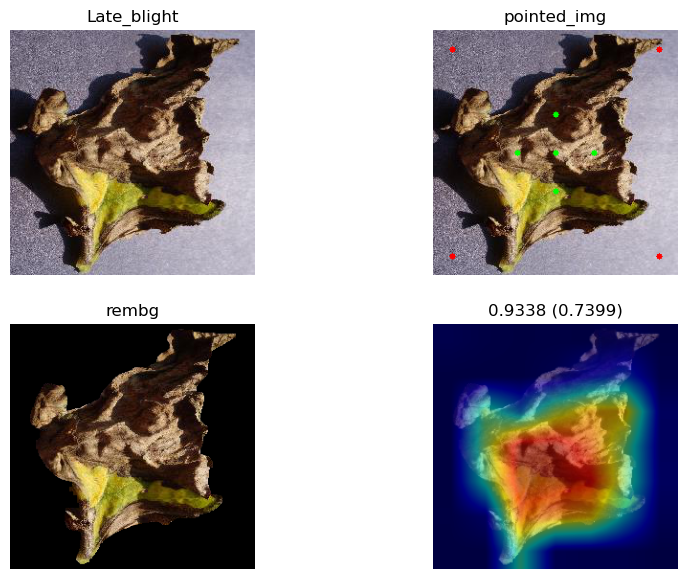

In [16]:
import matplotlib.pyplot as plt

random_img = random.choice(imgs)
# random_img = './data_test/la_tren_cay.jpg'
print(random_img)
img = Image.open(random_img)
results = await model.predict(img)

plt.figure(figsize=[10, 7])
plt.subplot(2, 2, 1)
plt.imshow(results['image'])
plt.title(results['class_name'])
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(results['pointed_img'])
plt.title('pointed_img')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(results['removed_bg_img'])
plt.title('rembg')
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(results['predicted_image'])
plt.title(f"{round(results['score'], 4)} ({round(results['threshold'], 4)})")
plt.axis("off")

In [2]:
from model.cnn_model import Cnn_model

model = Cnn_model('./runs/classify/train8/')

In [6]:
from PIL import Image

img = Image.open('./data_test/14685298-94df-4502-a5da-9fe8c388aa1b.jpg')

model.predict(img=img)

(tensor([[ 2.7538, -2.8498]]), 'leaf', 0.9963290095329285)

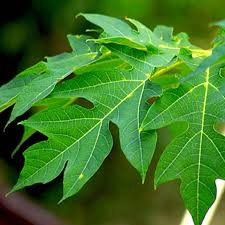

In [7]:
img